In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_data as prep

In [2]:
state = 'GO'

In [3]:
df = pd.read_csv('./data/dengue.csv.gz')

df = df.loc[df.uf == state]

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df_w = df[['casos']]

df_w = df_w.resample('W-SUN').sum()

df_w = prep.add_epiweek_label(df_w)

df_w.head()

/Users/eduardoaraujo/Documents/Github/lstm_transf_to_state/preprocess_data.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w['epiweek_label'] = df_w['epiweek_label'].apply(transform_epiweek_label)
/Users/eduardoaraujo/Documents/Github/lstm_transf_to_state/preprocess_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w['epiweek'] = df_w['epiweek_label'].astype(str).str[-2:].astype(int)
/Users/eduardoaraujo/Documents/Github/lstm_transf_to_state/preprocess_data.py:51: SettingWithCopyWarning: 

,casos,epiweek_label,epiweek,year
date,,,,
2010-01-03,5554,201013,13,2010
2010-01-10,6930,201014,14,2010
2010-01-17,7175,201015,15,2010
2010-01-24,7317,201016,16,2010
2010-01-31,7286,201017,17,2010


In [4]:
df_macro = pd.read_csv('./data/macro_saude.csv', index_col = 'Unnamed: 0')

df_macro = df_macro.loc[df_macro.state == state]

df_macro.head()

,geocode,name_muni,name_region,code_region,name_macro,code_macro,state
354,5208806,Goianira,Central,52001,Centro-Oeste,5208,GO
355,5208905,Goiás,Rio Vermelho,52012,Centro-Oeste,5208,GO
356,5209101,Goiatuba,Sul,52017,Centro Sudeste,5210,GO
393,5213756,Montividiu,Sudoeste I,52015,Sudoeste,5206,GO
394,5213772,Montividiu do Norte,Norte,52008,Centro-Norte,5209,GO


In [5]:
def get_samples(regional_geocodes, year):

    df_end = pd.DataFrame()

    for region in regional_geocodes: 

        df = pd.read_csv(f'./predictions_ensemble/{state}_{region}_{year}.csv.gz', index_col = 'Unnamed: 0')

        df_reg =  pd.DataFrame()
        df_reg[str(region)] = np.percentile(df.values, 50, axis=1)

        df_end = pd.concat([df_end, df_reg], axis = 1)

    target = pd.DataFrame()

    target['casos'] = df_w.loc[df_w.year==year].casos

    return df_end, target


    

In [6]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()

for year in np.arange(2013, 2023):
    
    X_train_, y_train_ = get_samples(regional_geocodes = df_macro.code_region.unique(), year= year)

    X_train = pd.concat([X_train, X_train_])
    y_train = pd.concat([y_train, y_train_])



In [7]:
X_train = X_train.fillna(0)

In [8]:
X_train.shape

(520, 18)

In [9]:
y_train.shape

(520, 1)

In [10]:
y_train.isnull().sum()

casos    0
dtype: int64

In [11]:
y_train_.values.ravel().shape

(52,)

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import HistGradientBoostingRegressor

In [14]:
param = {"max_iter": [100, 300, 500],
         "loss": ['squared_error'],
         # "l2_regularization":[0.0, 0.5, 1.0]
        }

cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [15]:
X_train.shape

(520, 18)

In [16]:
y_train.shape

(520, 1)

In [17]:
%%time  
hgbm = HistGradientBoostingRegressor(l2_regularization = 0.2)
    
grid_search = GridSearchCV(
            estimator=hgbm,
            param_grid=param,
            return_train_score=True,
            cv=cv,
        ).fit(X_train, y_train.values.ravel())


CPU times: user 1min 2s, sys: 24.2 s, total: 1min 26s
Wall time: 12.8 s


model = LinearRegression()

model.fit(X_train, y_train)

In [18]:
X_test, y_test = get_samples(regional_geocodes = df_macro.code_region.unique(), year= 2023)

In [19]:
pred_ = grid_search.predict(X_test)

pred = pred_

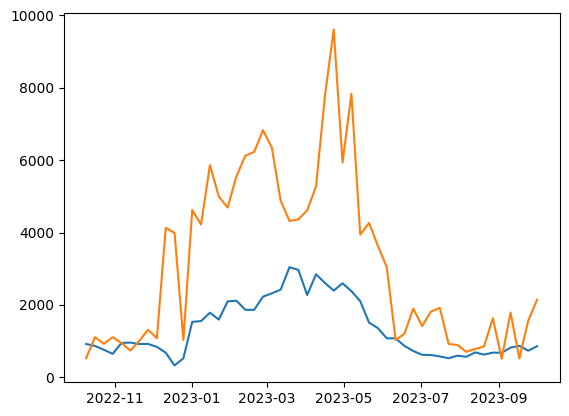

In [20]:
fig, ax = plt.subplots()

df_w_ = df_w.loc[df_w.year==2023]

ax.plot(df_w_.index, df_w_.casos)

ax.plot(df_w_.index, pred)

plt.show()